In [1]:
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, LabeledSentence

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

First, we'll take a look at what words are representative of the postive reviews and negative reviews. For this purpose, we'd like to keep only the words that carry the most sentiment meaning (i.e. verbs, nouns and adjectives)

In [2]:
train = pd.read_csv("labeledTrainData.tsv",
                    delimiter="\t",
                    header=0,
                    quoting=3)

train_sents_sentiment = pickle.load(open("train_sents_sentiment.pickle"))
train_sents_sentiment = [review.lower() for review in train_sents_sentiment]
y = train["sentiment"].values

As we did in Part 1, the processed text data contains only verbs, nouns and adjectives:

In [15]:
train_sents_sentiment[0]

u"stuff go moment mj start listen music watch odd documentary watch wiz watch moonwalker want get certain insight guy think cool eighty make mind guilty innocent moonwalker part biography part feature film remember go see cinema release subtle message mj feeling press obvious message drug bad m'kay impressive course michael jackson remotely mj go hate find bore call mj egotist consent making movie but mj fan say make fan true nice actual feature film bit start num minute exclude smooth criminal sequence joe pesci convince psychopathic powerful drug lord want mj dead bad mj overhear plan nah joe pesci character rant want people know supply drug dunno hat mj music lots cool thing like mj turn car robot whole speed demon sequence director patience saint come film kiddy bad sequence director hate work kid let whole bunch perform complex dance scene bottom line movie people like mj level think people stay try give wholesome message mj best buddy movie girl michael jackson talented people gr

First, we'll simply create the counter object for the words that appear in either category, and show the top 10 most frequent words

In [3]:
pos_counter = Counter()
neg_counter = Counter()

for doc, label in zip(train_sents_sentiment, y):
    words = doc.split()
    if label == 1:
        pos_counter.update(words)
    else:
        neg_counter.update(words)

In [4]:
pos_counter.most_common(10)

[(u'film', 24685),
 (u'movie', 22216),
 (u'num', 12266),
 (u'see', 10635),
 (u'make', 10090),
 (u'good', 9028),
 (u'get', 8156),
 (u'time', 7946),
 (u'story', 7322),
 (u'great', 6996)]

In [5]:
neg_counter.most_common(10)

[(u'movie', 28377),
 (u'film', 22257),
 (u'num', 13600),
 (u'make', 11992),
 (u'bad', 10508),
 (u'see', 9747),
 (u'get', 9710),
 (u'good', 9378),
 (u'time', 7357),
 (u'go', 7257)]

As we can see, these words are not very informative in distinguishing between the two categories. But there is one interesting observation: the word **good** appeared in the most common words in both postive and negative reviews. I've actually had a chance to skim over a couple of labeled reviews, and I noticed that some reviews started with a lengthy summarization of the plot of the movie, while ended with only a few short sentences expressing opinons about the movie itself. Maybe the word **good** was used very often in describing the movie, rather than indicating the movie is "good". 

To identify the most differentiating words, I tried the approach shown in the reddit project https://github.com/chao-ji/reddit/blob/master/Part%205%20Topics%20Over%20Time%20-%20Overrepresented%20Words.ipynb, that computes the log-odds ratio of the words that appear in both postive and negative reviews.

In [6]:
global_counter = Counter()
global_counter.update(pos_counter)
global_counter.update(neg_counter)

In [7]:
def zscore(word, counter_i, n_i, 
           counter_j, n_j,
           counter_0, n_0, log=np.log):
    """
    Input: the counter of words in corpus_i and corpus_j, and their sizes(n_i and n_j)
           the counter of words in background corpus_0, and size (n_0)
           
    Function for computing the log-odds ratio. The LARGER the zscore, the MORE overrepresented
    the word `word` is in corpus_i as opposed in corpus_j
    """
    y_i = np.float(counter_i[word])
    y_j = np.float(counter_j[word])
    a_w = np.float(counter_0[word])

    ratio_i = (y_i + a_w) / (n_i + n_0 - y_i - a_w)
    ratio_j = (y_j + a_w) / (n_j + n_0 - y_j - a_w)

    if ratio_i < 0.:
        raise ValueError("ratio_i is negative: %f\n" % ratio_i)
    if ratio_j < 0.:
        raise ValueError("ratio_j is negative: %f\n" % ratio_j)

    logratio = log(ratio_i) - log(ratio_j)

    try:
        var_logratio = 1. / (y_i + a_w) + 1. / (y_j + a_w)
    except ZeroDivisionError as inst:
        print inst

    try:
        z = logratio / np.sqrt(var_logratio)
    except Exception as inst:
        print inst

    return z

We need to find the common words that appear in both positive and negative reviews, and compute their zscores, and visualize the distribution of zscores

In [8]:
common = set(pos_counter.keys()) & set(neg_counter.keys())
common = list(common)

n_i = sum(pos_counter.values())
n_j = sum(neg_counter.values())
n_0 = sum(global_counter.values())

df = [(w, zscore(w, counter_i=pos_counter, n_i=n_i,
                 counter_j=neg_counter, n_j=n_j,
                 counter_0=global_counter, n_0=n_0)) for w in common]

In [9]:
df = pd.DataFrame(np.array(zip(*df)).T, columns=["word", "zscore"])
df["zscore"] = df["zscore"].astype(np.float)
df = df.sort_values(by="zscore")

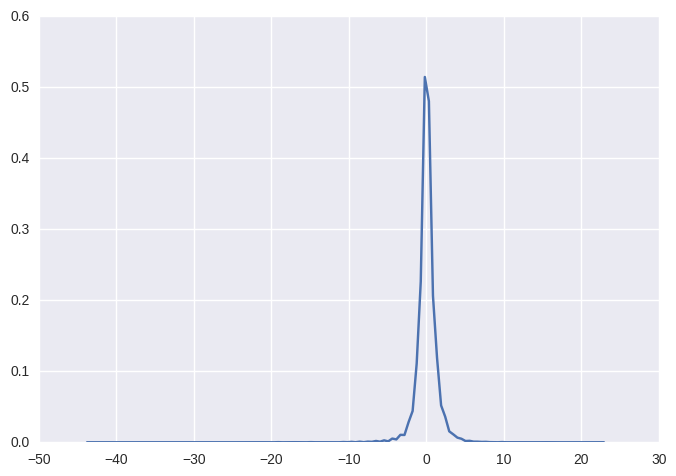

In [10]:
sns.kdeplot(df["zscore"].values)
plt.show()

It appears that the majority of words are used a lot in both positive and negative reviews. But we can visualize those words with high specificity using wordcloud:

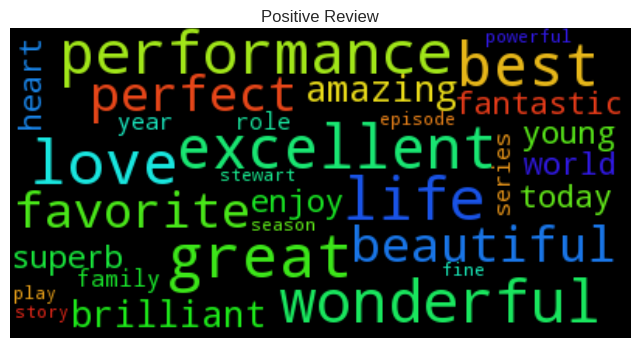

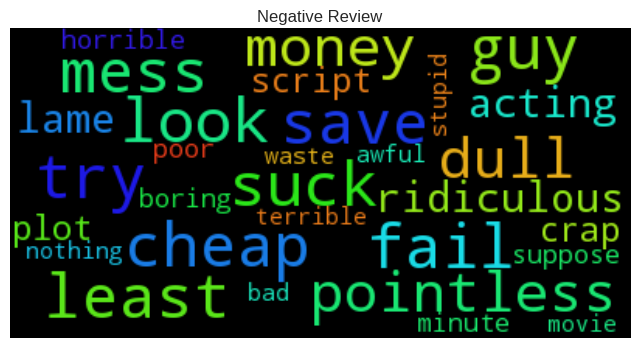

In [13]:
from wordcloud import WordCloud

pos = dict(df.iloc[-30:, :].values)
neg = dict(df.iloc[:30, :].values)

wc_pos = WordCloud(max_font_size=40).generate_from_frequencies((k, pos[k]) for k in pos.keys())
wc_neg = WordCloud(max_font_size=40).generate_from_frequencies((k, neg[k]) for k in neg.keys())

plt.imshow(wc_pos)
plt.title("Positive Review")
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(wc_neg)
plt.title("Negative Review")
plt.xticks([])
plt.yticks([])
plt.show()

In [14]:
train_sents_sentiment[0]

u"stuff go moment mj start listen music watch odd documentary watch wiz watch moonwalker want get certain insight guy think cool eighty make mind guilty innocent moonwalker part biography part feature film remember go see cinema release subtle message mj feeling press obvious message drug bad m'kay impressive course michael jackson remotely mj go hate find bore call mj egotist consent making movie but mj fan say make fan true nice actual feature film bit start num minute exclude smooth criminal sequence joe pesci convince psychopathic powerful drug lord want mj dead bad mj overhear plan nah joe pesci character rant want people know supply drug dunno hat mj music lots cool thing like mj turn car robot whole speed demon sequence director patience saint come film kiddy bad sequence director hate work kid let whole bunch perform complex dance scene bottom line movie people like mj level think people stay try give wholesome message mj best buddy movie girl michael jackson talented people gr

In [24]:
from gensim import corpora, models

In [25]:
reviews = [review.split() for review in train_sents_sentiment]

In [26]:
def process_corups(corpus, remove_singleton=True):
    corpus = [doc.split() for doc in corpus]
    
    if remove_singleton:
        freq = Counter()
        for doc in corpus:
            freq.update(doc)
    
        corpus = [[token for token in doc if freq[token] > 1] for doc in corpus]
        
    return corpus   

In [27]:
texts = process_corups(train_sents_sentiment)

In [31]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

lda = models.ldamulticore.LdaMulticore(corpus_tfidf, id2word=dictionary, num_topics=20, workers=4, alpha=0.001, passes=10)

In [33]:
lda.show_topics()

[(1,
  u'0.004*"rochester" + 0.004*"jane" + 0.002*"eyre" + 0.002*"dalton" + 0.002*"timberlake" + 0.002*"buffalo" + 0.002*"clarke" + 0.001*"bronte" + 0.001*"zelah" + 0.001*"contestant"'),
 (5,
  u'0.004*"movie" + 0.003*"film" + 0.003*"num" + 0.003*"bad" + 0.002*"watch" + 0.002*"good" + 0.002*"see" + 0.002*"show" + 0.002*"story" + 0.002*"make"'),
 (19,
  u'0.002*"judi" + 0.002*"imax" + 0.001*"dench" + 0.001*"grable" + 0.001*"dickinson" + 0.001*"angie" + 0.001*"tel" + 0.001*"aviv" + 0.001*"palma" + 0.001*"frewer"'),
 (13,
  u'0.003*"che" + 0.002*"gandhi" + 0.002*"welles" + 0.002*"carlito" + 0.002*"cbnum" + 0.002*"elvira" + 0.002*"snowman" + 0.001*"tomatoes" + 0.001*"guinness" + 0.001*"luise"'),
 (14,
  u'0.004*"columbo" + 0.002*"brosnan" + 0.001*"biggs" + 0.001*"heckle" + 0.001*"kinnear" + 0.001*"barbie" + 0.001*"lordi" + 0.001*"tomlinson" + 0.001*"knob" + 0.001*"gaelic"'),
 (2,
  u'0.002*"emma" + 0.002*"elvis" + 0.002*"affleck" + 0.002*"cole" + 0.001*"berkowitz" + 0.001*"tierney" + 0.001

In [34]:
import pyLDAvis
from pyLDAvis import gensim

data = gensim.prepare(lda, corpus_tfidf, dictionary)
pyLDAvis.display(data)